In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import networkx as nx

from rdkit import Chem
from rdkit.Chem import Draw

# import torch_geometric.data into environment
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv

from torch_geometric.nn.pool import global_mean_pool

from torch.utils.data import random_split

from torch_geometric.loader import DataLoader
import torch.nn.functional as F


import pikachu.general as pikachu #Unused

from utils import DrawMolToMPL

from pysmiles import read_smiles #Unused

from tqdm import tqdm

from time import time

# check if GPU is available and detectable. cpu is ok for this homework.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [2]:
class OneHotTransform:
    def __init__(self, untransformed):
        self.full_x = untransformed.x
        self.full_x_slices = untransformed.slices['x']
        self.full_edges = untransformed.edge_attr
        self.full_edge_slices = untransformed.slices["edge_index"]
        
        self.index = 0
        self.edge_index = 0

    def __call__(self, data: Data):
        tensors = []
        for i in range(self.full_x.shape[1]):
            unique, unique_indices = torch.unique(self.full_x[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_x[:, i].reshape(-1, 1))

        new_x = torch.cat(tensors, dim = 1)

        start = self.full_x_slices[self.index]
        end = self.full_x_slices[self.index + 1]
        data.x = new_x[start:end]


        tensors = []
        for i in range(self.full_edges.shape[1]):
            unique, unique_indices = torch.unique(self.full_edges[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_edges[:, i].reshape(-1, 1))

        new_edges = torch.cat(tensors, dim = 1)

        start = self.full_edge_slices[self.index]
        end = self.full_edge_slices[self.index + 1]
        data.edge_attr = new_edges[start:end]

        self.index += 1

        return data

In [3]:
dataset_name = "FreeSolv"
dataset_untransformed = MoleculeNet('./data', dataset_name)

Processing...
Done!


In [4]:
dataset_untransformed.slices

{'x': tensor([   0,   13,   18,   23,   31,   39,   48,   54,   61,   69,   74,   77,
           84,   92,  101,  108,  119,  128,  137,  145,  152,  162,  181,  189,
          196,  204,  210,  215,  223,  227,  232,  240,  245,  263,  274,  279,
          290,  298,  309,  316,  325,  330,  339,  350,  359,  371,  378,  387,
          391,  398,  405,  410,  416,  424,  435,  439,  449,  451,  458,  471,
          487,  496,  497,  511,  522,  533,  537,  552,  556,  560,  568,  576,
          596,  603,  612,  619,  622,  629,  643,  647,  656,  668,  677,  685,
          694,  698,  700,  705,  712,  719,  724,  742,  756,  759,  772,  776,
          780,  789,  793,  800,  820,  824,  831,  838,  841,  854,  864,  870,
          878,  883,  896,  907,  911,  919,  935,  943,  953,  958,  965,  974,
          992, 1001, 1015, 1018, 1027, 1035, 1041, 1055, 1057, 1070, 1074, 1079,
         1084, 1091, 1101, 1109, 1123, 1139, 1146, 1153, 1159, 1162, 1181, 1185,
         1190, 1198, 12

In [5]:
tensors = []
for i in range(dataset_untransformed.x.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.x[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        tensors.append(dataset_untransformed.x[:, i].reshape(-1, 1))

new_x = torch.cat(tensors, dim = 1)
print(new_x.shape)

print("Atomic number (one-hot), chirality (one-hot), degree (one-hot), valence (one-hot), number of bonded hydrogens (one-hot), number of radicals (omitted), hybridization (one-hot), aromatic, in ring")

edge_tensors = []
for i in range(dataset_untransformed.edge_attr.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.edge_attr[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        edge_tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        edge_tensors.append(dataset_untransformed.edge_attr[:, i].reshape(-1, 1))

new_x = torch.cat(edge_tensors, dim = 1)
print(new_x.shape)

print("Aromaticity, bond stereochemistry, conjugation")

Unique values, column 0
tensor([ 6,  7,  8,  9, 15, 16, 17, 35, 53])
9
Unique values, column 1
tensor([0, 1, 2])
3
Unique values, column 2
tensor([1, 2, 3, 4])
4
Unique values, column 3
tensor([4, 5, 6, 7])
4
Unique values, column 4
tensor([0, 1, 2, 3, 4])
5
Unique values, column 5
tensor([0])
1
Unique values, column 6
tensor([2, 3, 4])
3
Unique values, column 7
tensor([0, 1])
2
Unique values, column 8
tensor([0, 1])
2
torch.Size([5600, 30])
Atomic number (one-hot), chirality (one-hot), degree (one-hot), valence (one-hot), number of bonded hydrogens (one-hot), number of radicals (omitted), hybridization (one-hot), aromatic, in ring
Unique values, column 0
tensor([ 1,  2,  3, 12])
4
Unique values, column 1
tensor([0, 2, 3])
3
Unique values, column 2
tensor([0, 1])
2
torch.Size([10770, 8])
Aromaticity, bond stereochemistry, conjugation


In [6]:

dataset = MoleculeNet('./data', dataset_name, pre_transform = OneHotTransform(dataset_untransformed), force_reload = True)

c:\Users\mrwun\anaconda3\envs\geometric\Lib\site-packages\torch_geometric\data\dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
Processing...
Done!


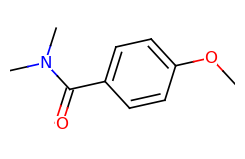

In [7]:
def draw_smiles(smiles_string, fig = None, ax = None):
    molecule = Chem.MolFromSmiles(smiles_string)

    if fig == None:
        fig = plt.gcf()
    if ax == None:
        ax = fig.gca()
    
    DrawMolToMPL(molecule, fig, ax)

fig = plt.figure()
ax = plt.subplot(121)
draw_smiles(dataset[0].smiles)
plt.show()

In [8]:
dataset[1].edge_attr

tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0]])

In [9]:

dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train dataset: {len(train_dataset)} graphs")
print(f"Val dataset: {len(val_dataset)} graphs")
print(f"Test dataset: {len(test_dataset)} graphs")

Train dataset: 385 graphs
Val dataset: 128 graphs
Test dataset: 129 graphs


In [10]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim, heads=8, dropout=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.relu = torch.nn.ReLU()
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.conv3 = GATv2Conv(hidden_channels * heads, in_channels, heads=1, dropout=dropout, edge_dim = edge_dim)

        self.conv_single = GATv2Conv(in_channels, in_channels, heads = 1, dropout = dropout, edge_dim = edge_dim)
        self.linear_1 = torch.nn.Linear(in_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.edge_attr
        attn_weights = [None] * 3
        x, attn_weights[0] = self.conv1(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[1] = self.conv2(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[2] = self.conv3(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        
        #x, attn_weights[0] = self.conv_single(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)

        x = self.relu(x)
        x = self.linear_1(x)
        x = nn.pool.global_mean_pool(x, data.batch)
        return x, attn_weights

In [11]:
import sys
test_loader = DataLoader(train_dataset, shuffle = False, batch_size = 2)


in_dimensions = dataset.x.shape[1]
edge_dimensions = dataset.edge_attr.shape[1]
print(in_dimensions)
print(edge_dimensions)
model = GAT(in_dimensions, 60, edge_dimensions)
print(train_dataset[0].x.dtype)
print(train_dataset[0].x)
i = next(iter(test_loader))
y_pred, attn = model(i)
print(y_pred)

30
8
torch.int64
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 1, 1]])
tensor([[0.1758],
        [0.1796]], grad_fn=<DivBackward0>)


In [12]:
def train(model, loader, optimizer, loss_fn, epoch_no):
    epoch_loss = 0
    model.train()

    epoch_iter = tqdm(loader, desc = "Train", ncols = 130)
    for batch in epoch_iter:
        optimizer.zero_grad()
        y_pred, _ = model(batch)

        loss = loss_fn(y_pred, batch.y)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iter.set_description(f"epoch: {epoch_no}, train_loss: {loss:.4f}")


    return epoch_loss/len(loader)


@torch.no_grad()
def test(model, loader, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, _ = model(batch)
            loss = loss_fn(y_pred, batch.y)

            epoch_loss += loss.item()
    
    return epoch_loss/len(loader)   

In [13]:
EPOCHS = 40
BATCH_SIZE = 20

in_dimensions = dataset.x.shape[1]
print(in_dimensions)
model = GAT(in_dimensions, in_dimensions * 2, edge_dimensions)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = torch.nn.MSELoss()


train_loader = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle = True, batch_size = BATCH_SIZE)

all_epochs = np.arange(EPOCHS)
all_train_loss = []
all_val_loss = []

for epoch in all_epochs:

    start_time = time()  # record the start time

    train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
    all_train_loss.append(train_loss)

    end_time = time()

    epoch_time = end_time - start_time

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_time}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

    val_loss = test(model, val_loader, loss_fn)
    all_val_loss.append(val_loss)
    print(f'Val Loss: {val_loss:.3f}')




30


epoch: 0, train_loss: 6.1136: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.20it/s]


Epoch: 01 | Epoch Time: 1.4085931777954102s
	Train Loss: 19.902


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 40.19it/s]


Val Loss: 13.755


epoch: 1, train_loss: 15.0551: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.11it/s]


Epoch: 02 | Epoch Time: 1.1688556671142578s
	Train Loss: 14.743


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 46.68it/s]


Val Loss: 11.873


epoch: 2, train_loss: 10.5051: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.05it/s]


Epoch: 03 | Epoch Time: 0.9974608421325684s
	Train Loss: 12.506


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 41.89it/s]


Val Loss: 9.900


epoch: 3, train_loss: 10.0285: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch: 04 | Epoch Time: 0.7728977203369141s
	Train Loss: 10.535


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 77.54it/s]


Val Loss: 7.626


epoch: 4, train_loss: 3.6244: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.99it/s]


Epoch: 05 | Epoch Time: 0.8002591133117676s
	Train Loss: 8.173


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 67.45it/s]


Val Loss: 7.722


epoch: 5, train_loss: 2.7787: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.83it/s]


Epoch: 06 | Epoch Time: 0.9601936340332031s
	Train Loss: 6.482


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 45.47it/s]


Val Loss: 5.988


epoch: 6, train_loss: 2.4697: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.38it/s]


Epoch: 07 | Epoch Time: 1.4010589122772217s
	Train Loss: 6.026


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 44.73it/s]


Val Loss: 4.856


epoch: 7, train_loss: 7.6898: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.72it/s]


Epoch: 08 | Epoch Time: 1.1958692073822021s
	Train Loss: 5.248


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.55it/s]


Val Loss: 4.201


epoch: 8, train_loss: 2.4964: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.12it/s]


Epoch: 09 | Epoch Time: 1.2420079708099365s
	Train Loss: 4.763


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 46.52it/s]


Val Loss: 4.040


epoch: 9, train_loss: 1.8622: 100%|███████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.02it/s]


Epoch: 10 | Epoch Time: 1.541849136352539s
	Train Loss: 3.969


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 40.91it/s]


Val Loss: 4.964


epoch: 10, train_loss: 4.5404: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.01it/s]


Epoch: 11 | Epoch Time: 1.4302701950073242s
	Train Loss: 4.733


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.44it/s]


Val Loss: 4.710


epoch: 11, train_loss: 5.2742: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch: 12 | Epoch Time: 1.2152810096740723s
	Train Loss: 4.333


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 40.96it/s]


Val Loss: 3.691


epoch: 12, train_loss: 2.8916: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.12it/s]


Epoch: 13 | Epoch Time: 0.8321301937103271s
	Train Loss: 3.646


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 54.04it/s]


Val Loss: 4.383


epoch: 13, train_loss: 0.9716: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.17it/s]


Epoch: 14 | Epoch Time: 0.7377288341522217s
	Train Loss: 3.143


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 75.88it/s]


Val Loss: 3.970


epoch: 14, train_loss: 5.4275: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.26it/s]


Epoch: 15 | Epoch Time: 0.7493135929107666s
	Train Loss: 3.512


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 77.59it/s]


Val Loss: 3.682


epoch: 15, train_loss: 13.3799: 100%|█████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.04it/s]


Epoch: 16 | Epoch Time: 0.7480587959289551s
	Train Loss: 4.037


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.71it/s]


Val Loss: 3.823


epoch: 16, train_loss: 4.0810: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.18it/s]


Epoch: 17 | Epoch Time: 0.7499537467956543s
	Train Loss: 2.904


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.51it/s]


Val Loss: 3.335


epoch: 17, train_loss: 4.4815: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.31it/s]


Epoch: 18 | Epoch Time: 0.7065186500549316s
	Train Loss: 2.827


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 80.48it/s]


Val Loss: 3.274


epoch: 18, train_loss: 5.6210: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.60it/s]


Epoch: 19 | Epoch Time: 0.7082040309906006s
	Train Loss: 2.532


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.45it/s]


Val Loss: 3.886


epoch: 19, train_loss: 3.2949: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.53it/s]


Epoch: 20 | Epoch Time: 0.7163655757904053s
	Train Loss: 2.445


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 71.42it/s]


Val Loss: 3.389


epoch: 20, train_loss: 2.3667: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.21it/s]


Epoch: 21 | Epoch Time: 0.6879096031188965s
	Train Loss: 2.658


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.17it/s]


Val Loss: 3.092


epoch: 21, train_loss: 1.7462: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch: 22 | Epoch Time: 0.7675864696502686s
	Train Loss: 2.786


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.06it/s]


Val Loss: 3.347


epoch: 22, train_loss: 2.3556: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.08it/s]


Epoch: 23 | Epoch Time: 0.7123215198516846s
	Train Loss: 2.666


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 76.58it/s]


Val Loss: 3.385


epoch: 23, train_loss: 1.7811: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.02it/s]


Epoch: 24 | Epoch Time: 0.7161798477172852s
	Train Loss: 2.468


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 71.65it/s]


Val Loss: 2.990


epoch: 24, train_loss: 3.9379: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.12it/s]


Epoch: 25 | Epoch Time: 0.8340206146240234s
	Train Loss: 2.279


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 44.27it/s]


Val Loss: 3.072


epoch: 25, train_loss: 2.1485: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.42it/s]


Epoch: 26 | Epoch Time: 0.6819734573364258s
	Train Loss: 2.688


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.48it/s]


Val Loss: 3.127


epoch: 26, train_loss: 1.9535: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.03it/s]


Epoch: 27 | Epoch Time: 0.7684857845306396s
	Train Loss: 1.985


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 71.95it/s]


Val Loss: 3.031


epoch: 27, train_loss: 2.9519: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.97it/s]


Epoch: 28 | Epoch Time: 0.6903095245361328s
	Train Loss: 2.311


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 73.25it/s]


Val Loss: 2.952


epoch: 28, train_loss: 1.1384: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.88it/s]


Epoch: 29 | Epoch Time: 0.7174267768859863s
	Train Loss: 2.325


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.10it/s]


Val Loss: 2.792


epoch: 29, train_loss: 0.6419: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.03it/s]


Epoch: 30 | Epoch Time: 0.7058868408203125s
	Train Loss: 2.273


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 81.37it/s]


Val Loss: 3.087


epoch: 30, train_loss: 0.9134: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch: 31 | Epoch Time: 0.7794909477233887s
	Train Loss: 1.952


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.75it/s]


Val Loss: 3.722


epoch: 31, train_loss: 1.1047: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.37it/s]


Epoch: 32 | Epoch Time: 0.7585484981536865s
	Train Loss: 1.905


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 74.39it/s]


Val Loss: 2.835


epoch: 32, train_loss: 1.6473: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.03it/s]


Epoch: 33 | Epoch Time: 0.6888582706451416s
	Train Loss: 2.026


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 81.64it/s]


Val Loss: 2.774


epoch: 33, train_loss: 3.1558: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.65it/s]


Epoch: 34 | Epoch Time: 0.7001152038574219s
	Train Loss: 2.184


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 45.66it/s]


Val Loss: 2.996


epoch: 34, train_loss: 3.1519: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.85it/s]


Epoch: 35 | Epoch Time: 0.846916913986206s
	Train Loss: 2.207


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 60.49it/s]


Val Loss: 2.549


epoch: 35, train_loss: 1.6550: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.13it/s]


Epoch: 36 | Epoch Time: 0.6966664791107178s
	Train Loss: 1.897


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 82.85it/s]


Val Loss: 2.669


epoch: 36, train_loss: 2.0673: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.26it/s]


Epoch: 37 | Epoch Time: 0.7918860912322998s
	Train Loss: 1.921


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.89it/s]


Val Loss: 2.599


epoch: 37, train_loss: 0.9407: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.30it/s]


Epoch: 38 | Epoch Time: 0.6847946643829346s
	Train Loss: 2.012


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 79.83it/s]


Val Loss: 2.841


epoch: 38, train_loss: 4.1507: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.33it/s]


Epoch: 39 | Epoch Time: 0.6908040046691895s
	Train Loss: 1.690


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.17it/s]


Val Loss: 2.863


epoch: 39, train_loss: 0.8462: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.53it/s]


Epoch: 40 | Epoch Time: 0.7009694576263428s
	Train Loss: 2.222


Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 76.97it/s]

Val Loss: 2.619


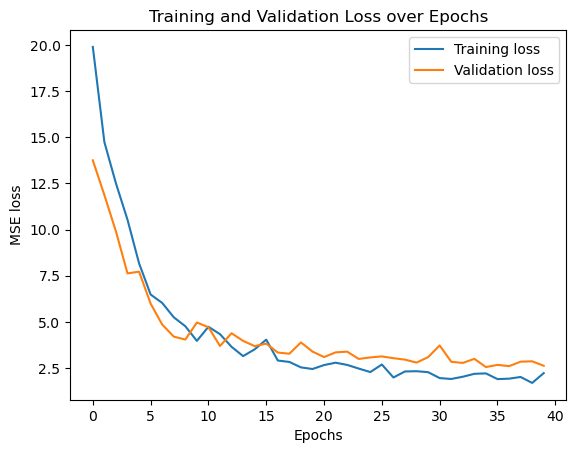

In [14]:
plt.figure()
plt.title("Training and Validation Loss over Epochs")
plt.plot(all_epochs, all_train_loss, label = "Training loss")
plt.plot(all_epochs, all_val_loss, label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

In [15]:
def detailed_predictions(model, loader):
    model.eval()
    epoch_loss = 0

    all_y = []
    all_y_pred = []
    all_inputs = []
    all_attn = []
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, attn = model(batch)
            all_inputs.append(batch)
            all_attn.append(attn)
            loss = loss_fn(y_pred, batch.y)

            epoch_loss += loss.item()

            all_y_pred.append(y_pred.reshape([-1]))
            all_y.append(batch.y.reshape([-1]))
        
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred).numpy()

            
    
    return epoch_loss/len(loader), all_inputs, all_y, all_y_pred, all_attn

In [16]:
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 1)
loss, all_inputs, all_y, all_y_pred, all_attn = detailed_predictions(model, test_loader)

Eval: 100%|████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 104.85it/s]


In [17]:
print(loss)

1.6904708172970677


In [18]:
from scipy.stats import linregress

[ -0.56  -0.59  -2.44  -6.23   2.11  -4.13  -0.9   -4.57  -0.48  -0.9
   1.92   1.47  -9.2   -6.55  -2.38  -6.74  -0.89  -5.9    0.5    2.71
  -7.66  -7.78  -2.75   1.66  -2.33   2.51 -12.64  -2.49  -0.95  -2.47
   0.06   0.67  -1.93  -1.16  -3.71  -3.11  -2.81  -6.35  -4.8   -1.69
   0.52  -5.48  -2.64  -4.7   -1.27  -2.64  -1.14  -7.1   -4.21   0.18
   2.52  -6.96  -4.69  -5.18  -6.27  -4.39  -6.25  -2.49   2.38  -6.5
  -6.46  -2.4   -3.28  -1.24  -6.09  -5.46  -1.17  -4.58  -6.21  -4.59
   0.    -4.39  -4.22  -0.14  -3.37  -5.91  -1.4   -2.53  -2.83  -0.45
   2.56  -3.22  -5.66  -1.45  -3.34   2.06   2.97  -4.82  -3.93  -6.69
  -4.4  -18.06  -0.82  -3.52  -3.79  -3.48  -4.77  -4.61  -1.82  -3.25
  -4.02  -3.64  -2.55  -5.73  -3.84   2.    -9.37  -2.21 -10.17   0.29
  -4.68  -4.78  -5.88  -4.61  -6.5   -0.74  -4.85  -3.24  -6.68  -5.21
  -6.32  -3.45  -2.46   0.71  -3.13 -20.52  -3.67 -10.78  -4.97]
[-3.0554494e-01  3.0750480e-01 -2.6862490e+00 -6.3197265e+00
  2.3452835e+00 -5.08368

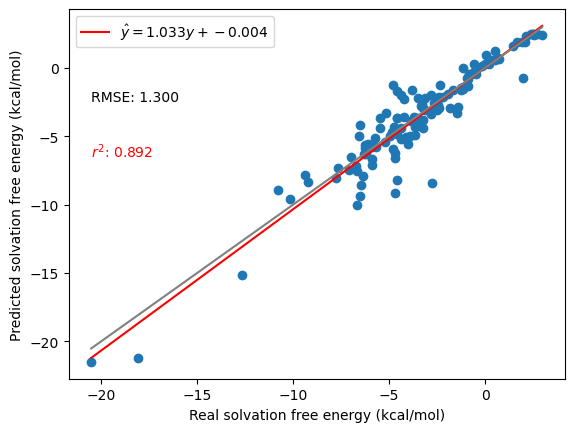

In [19]:
print(all_y)
print(all_y_pred)
plt.scatter(all_y, all_y_pred)

if dataset_name == "ESOL":
    plt.xlabel("Real solubility (log(M))")
    plt.ylabel("Predicted solubility (log(M))")
elif dataset_name == "FreeSolv":
    plt.xlabel("Real solvation free energy (kcal/mol)")
    plt.ylabel("Predicted solvation free energy (kcal/mol)")

x_vals = np.linspace(np.min(all_y), np.max(all_y), 10)

result = linregress(all_y, all_y_pred)
print(all_y)

plt.plot(x_vals, result.slope * x_vals + result.intercept, c = "red", label = r"$\hat{y}=" + f"{result.slope:.3f}y+{result.intercept:.3f}$")

plt.text(min(all_y), (plt.ylim()[1] - plt.ylim()[0]) * 0.75 + plt.ylim()[0], f"RMSE: {np.sqrt(loss):.3f}")
plt.text(min(all_y), (plt.ylim()[1] - plt.ylim()[0]) * 0.6 + plt.ylim()[0], f"$r^2$: {result.rvalue**2:.3f}", c = "red")
plt.legend()
plt.plot(x_vals, x_vals, c = 'grey')

['CCCBr']


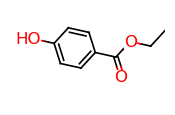

In [20]:
input = all_inputs[12]
plt.figure(figsize=(2, 2))
draw_smiles(input.smiles[0], fig = plt.gcf())
print(all_inputs[0].smiles)

In [21]:
def my_draw_networkx_edge_labels(
        #https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

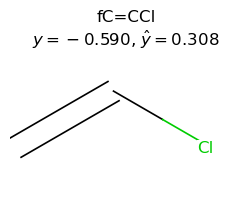

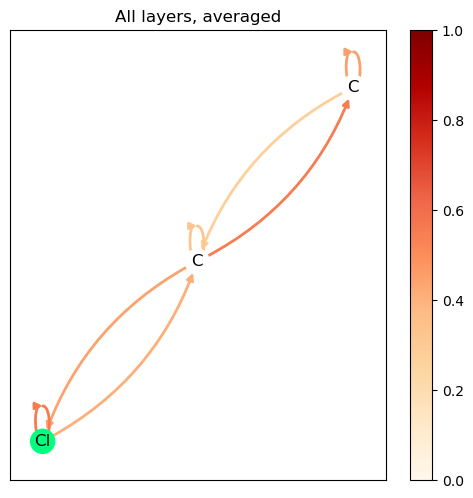

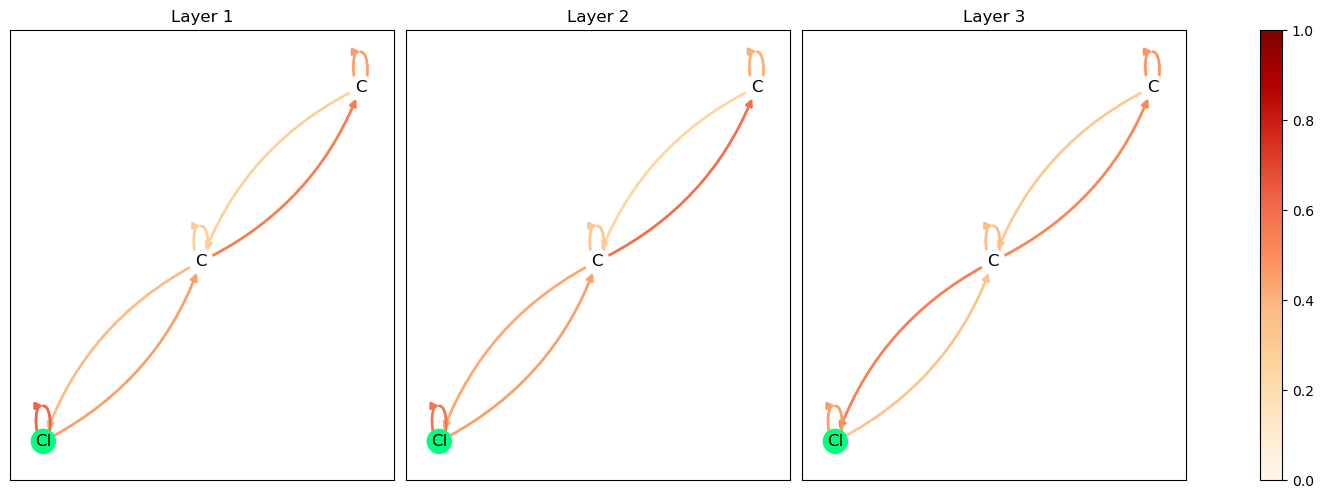

In [22]:
def visualize_attention_map(all_attn, smiles, y, y_hat, rad = 0.2, labels = True, cmap = plt.cm.gist_heat, averaged = False):
    if len(all_attn)  > 1:
        layer_averaged_attn = ((all_attn[0][0], torch.mean((torch.stack([torch.mean(t[1], dim = 1).unsqueeze(0).reshape((-1, 1)) for t in all_attn])), dim = 0)))
        visualize_attention_map([layer_averaged_attn], smiles, y, y_hat, rad, labels, cmap, averaged = True)
    else:
        plt.figure(figsize = (3, 3))
        plt.title(f"f{smiles}\n$y = {y:.3f}$," + r" $\hat{y}" + f" = {y_hat:.3f}$")
        draw_smiles(smiles)
        plt.show()

    plt.figure(figsize = (5 * len(all_attn), 5))
    ax_list = [None] * len(all_attn)
    for i, tup in enumerate(all_attn):
        #plt.suptitle("Averaged Attention Weights")
        ax_list[i] = plt.subplot( 1, len(all_attn), i+1)
        
        if not averaged:
            plt.title(f"Layer {i + 1}")
        else:
            plt.title("All layers, averaged")

        edge_index = tup[0]
        attentions = tup[1]
        #print(tuple)

        averaged_attention = torch.mean(attentions, dim = 1)
        g = read_smiles(smiles).to_directed()

        pos = nx.kamada_kawai_layout(g)
        
        g.add_weighted_edges_from([(edge_index[0, i].item(), edge_index[1, i].item(), averaged_attention[i].item()) for i in range(edge_index.shape[1])])

        
        node_colors = {'C': 'white', 'O': 'lightcoral', 'N': 'cornflowerblue', 'Cl': 'springgreen', 'Br': 'peru'}
        elements = nx.get_node_attributes(g, name = "element")
        edge_weights = nx.get_edge_attributes(g, name = "weight")

        color_map = [node_colors.get(element, 'white') for element in elements.values()]


        nx.draw_networkx_nodes(g, label = elements, pos=pos, node_color = color_map)
        nx.draw_networkx_labels(g, pos, elements)
        #
        #width= (10 * (np.array(list(edge_weights.values()))))
        collection = nx.draw_networkx_edges(g, pos, edge_weights.keys(), edge_color=edge_weights.values(), edge_cmap=cmap, width= 2, arrows = True, connectionstyle=f'arc3, rad = {rad}', edge_vmin = 0, edge_vmax = 1)
        

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))


        
        if labels:
            my_draw_networkx_edge_labels(g, pos, {i: f"{edge_weights[i]:.2f}" for i in edge_weights.keys()}, rad = rad, rotate = False)
        #plt.gca().set_aspect('equal')

        plt.tight_layout()
        if i == len(all_attn) - 1:
            plt.colorbar(sm, ax = ax_list)
        #plt.colorbar()
    plt.show()


graph_num = 1
visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


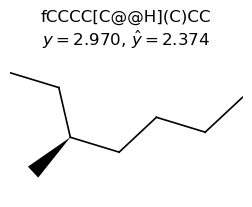

Atom "[C@@H]" contains stereochemical information that will be discarded.


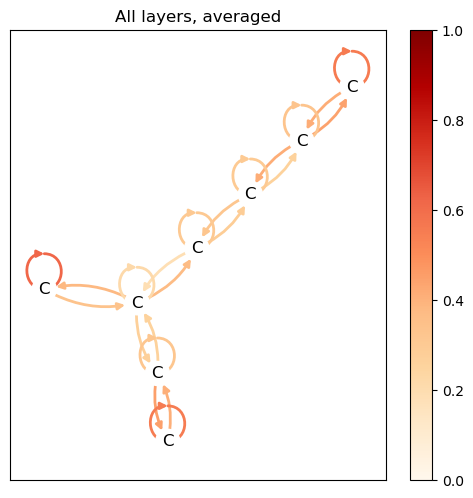

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.


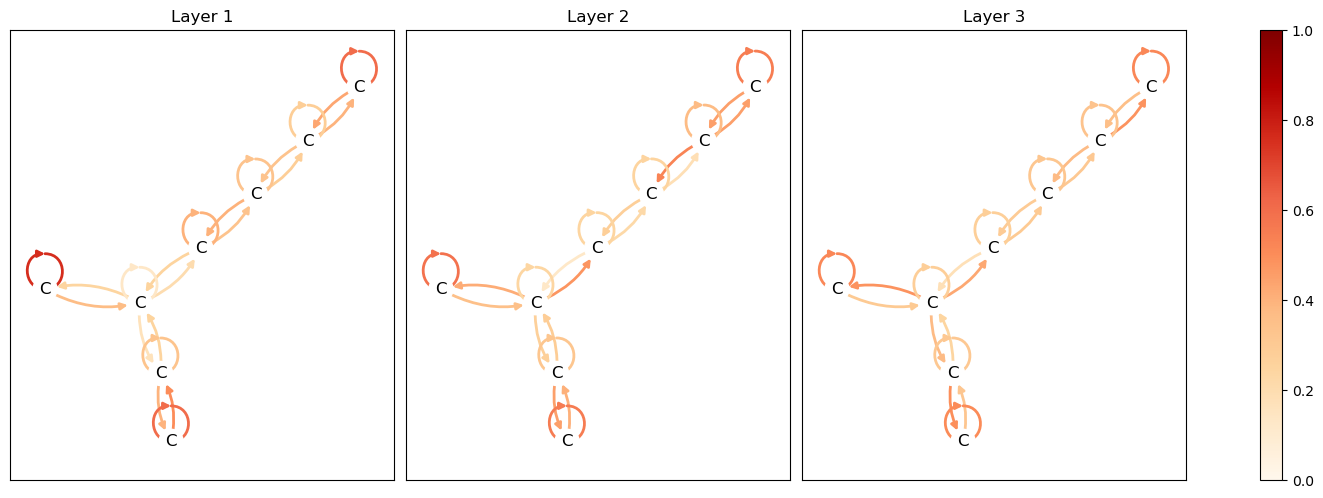

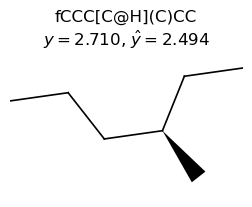

Atom "[C@H]" contains stereochemical information that will be discarded.


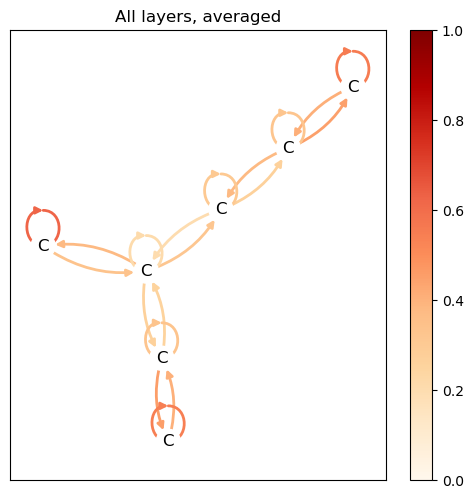

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


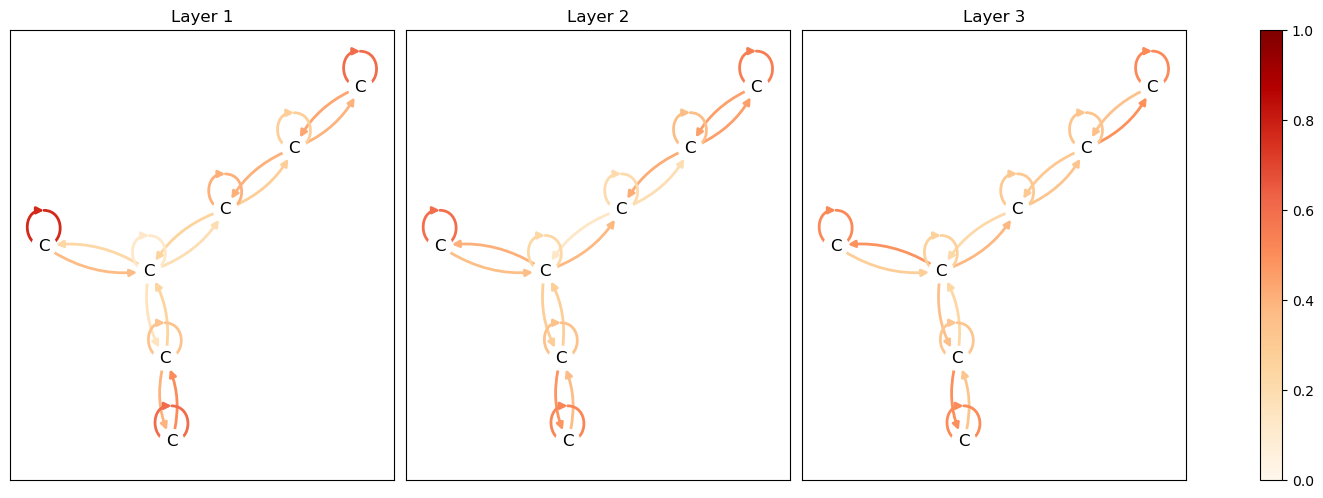

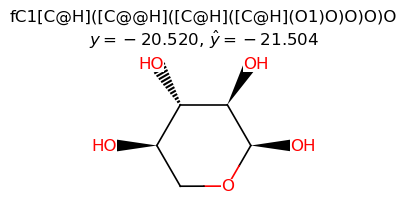

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


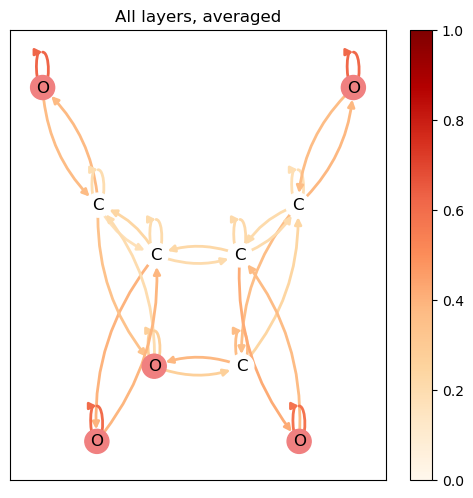

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


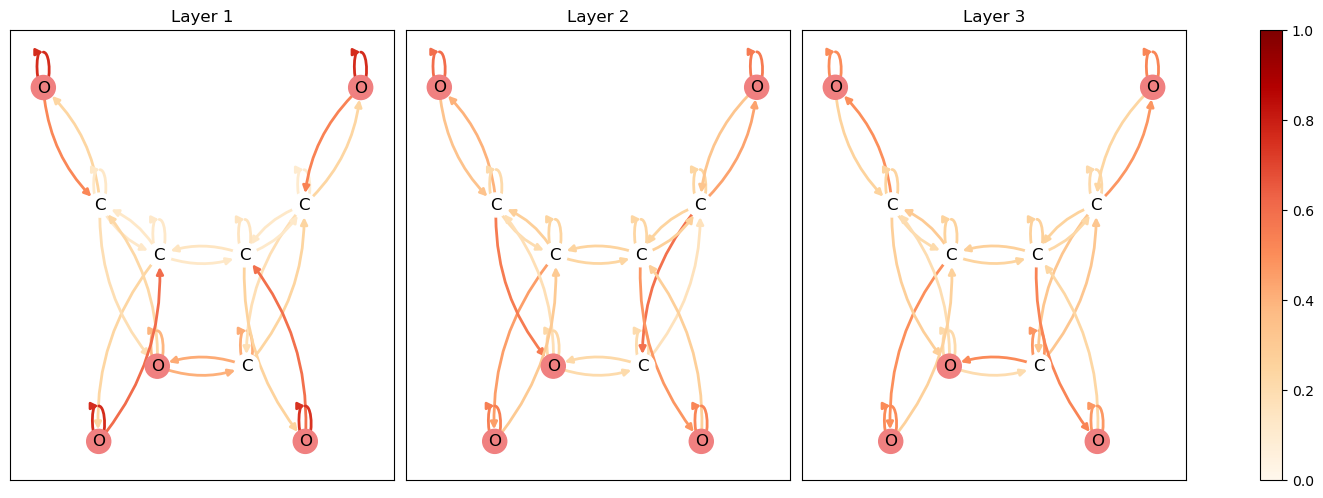

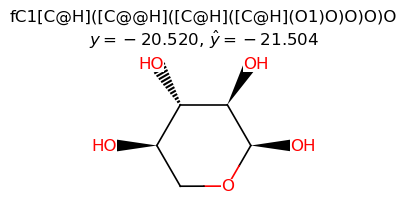

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


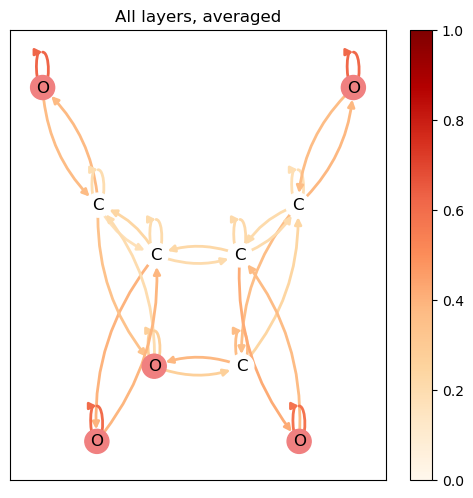

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


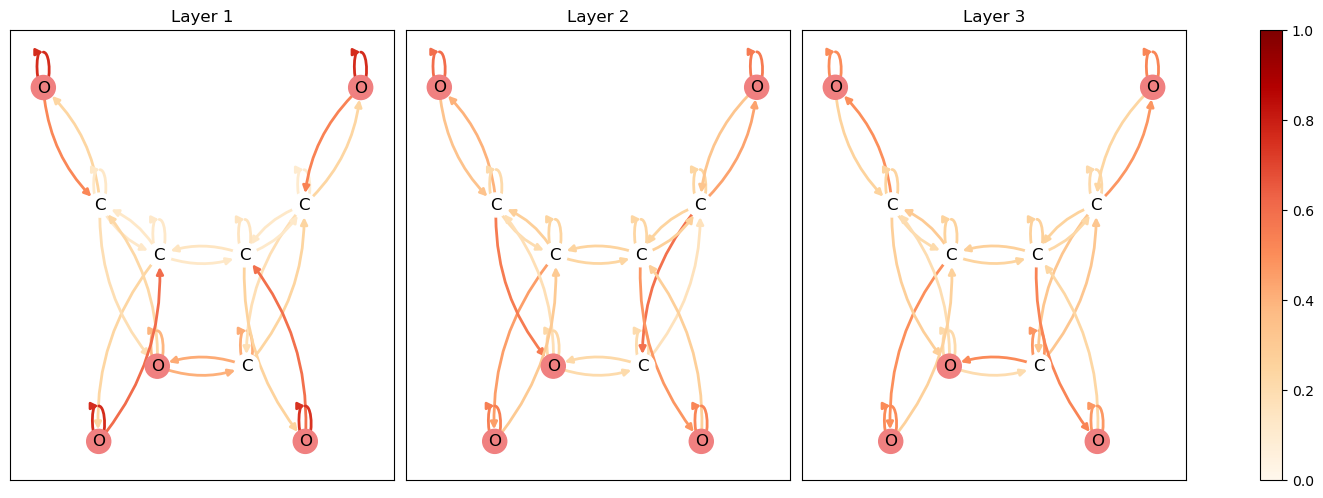

In [23]:
indices_of_interest = [np.argmax(all_y), np.argmax(all_y_pred), np.argmin(all_y), np.argmin(all_y_pred)]

for graph_num in indices_of_interest:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


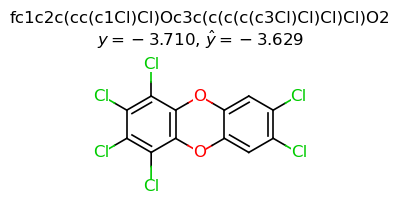

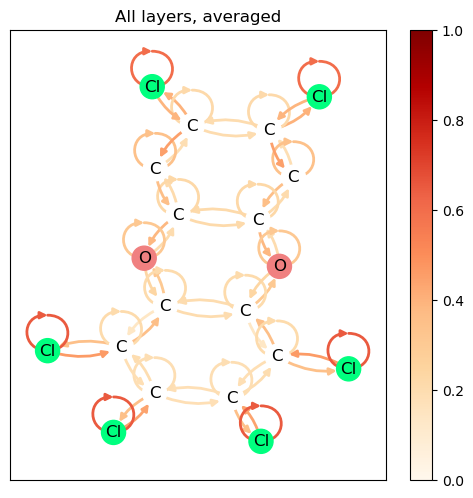

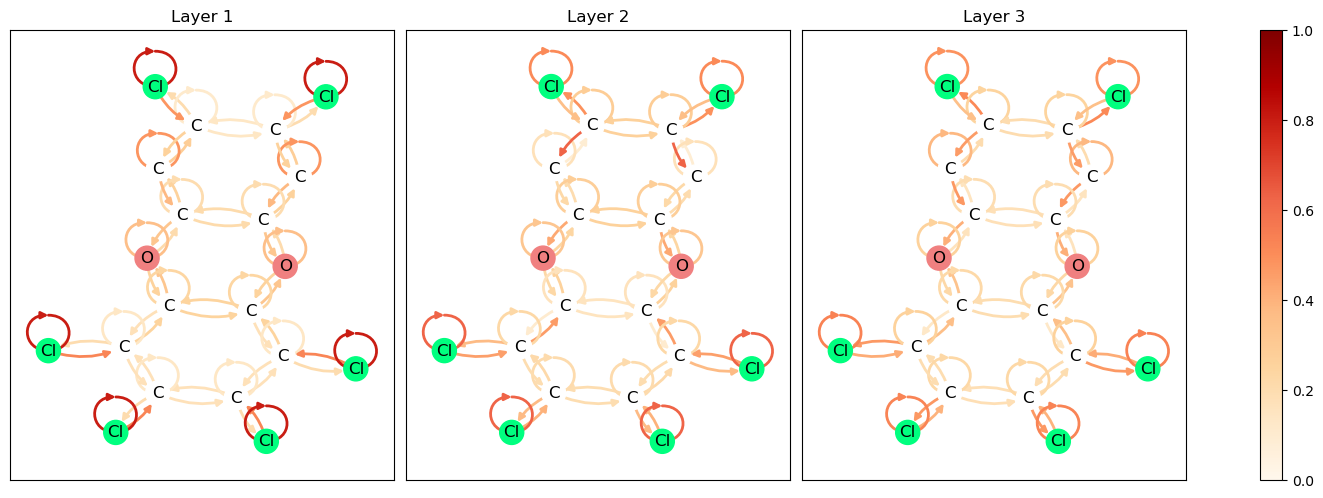

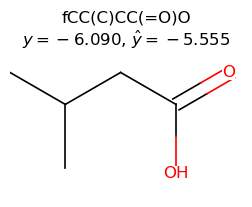

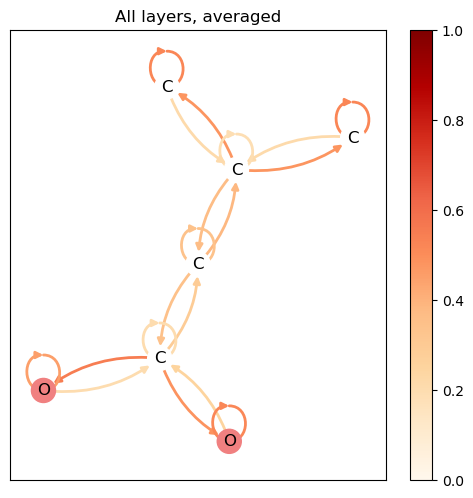

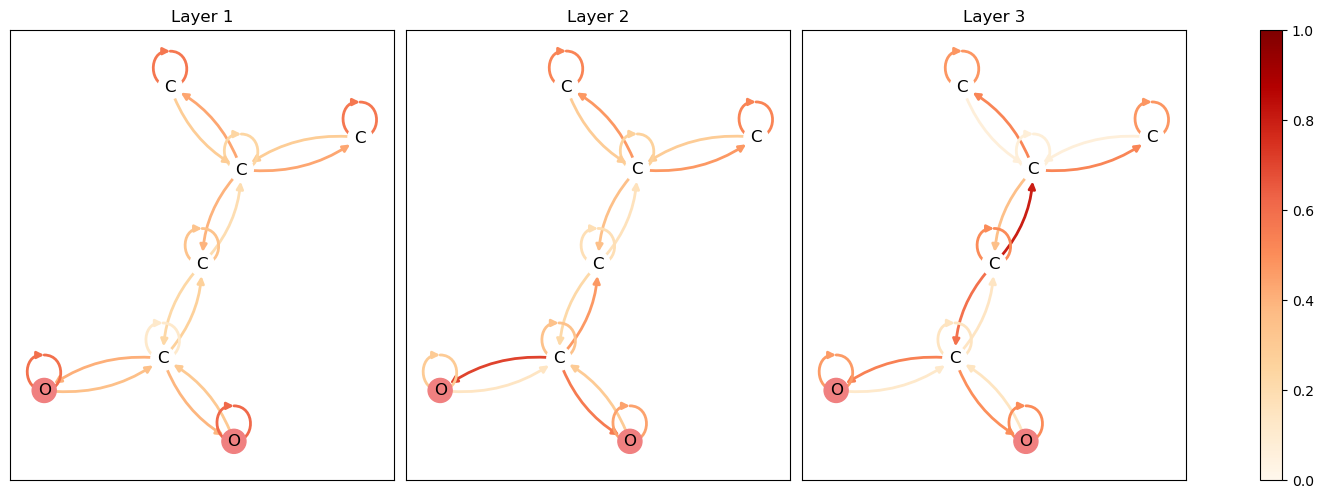

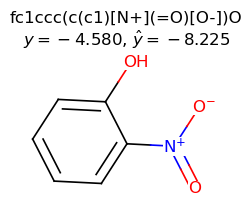

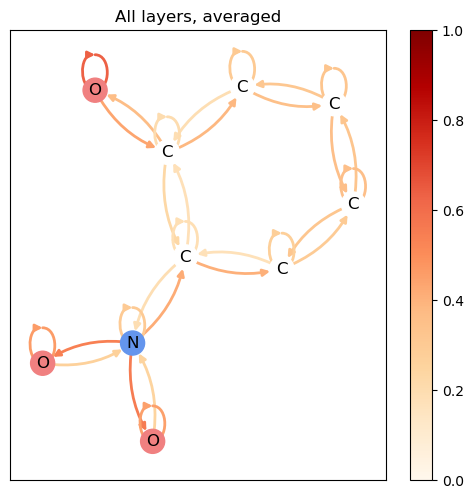

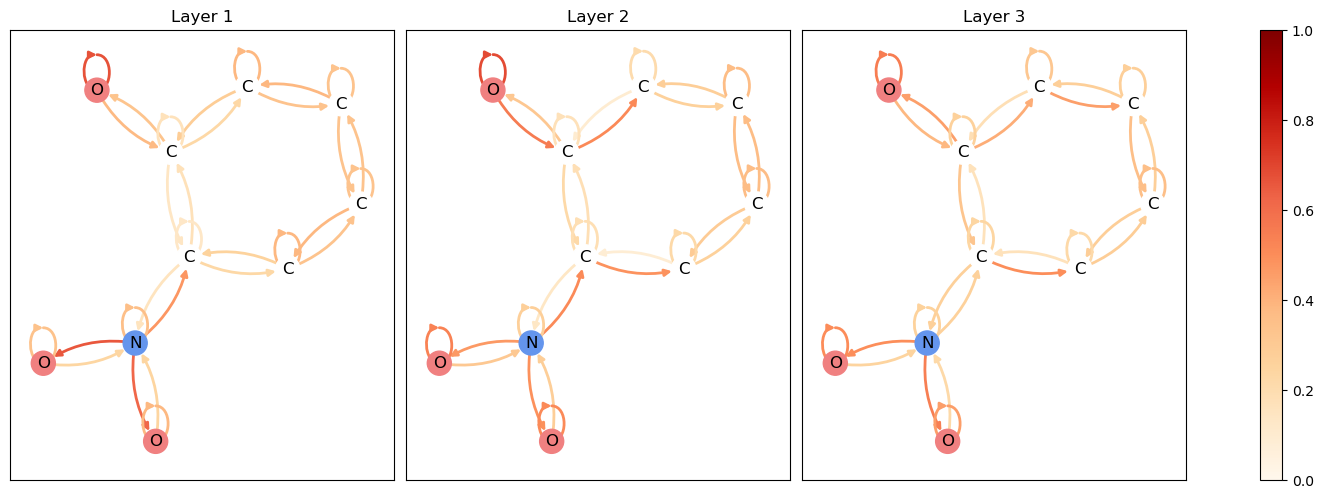

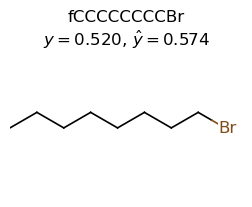

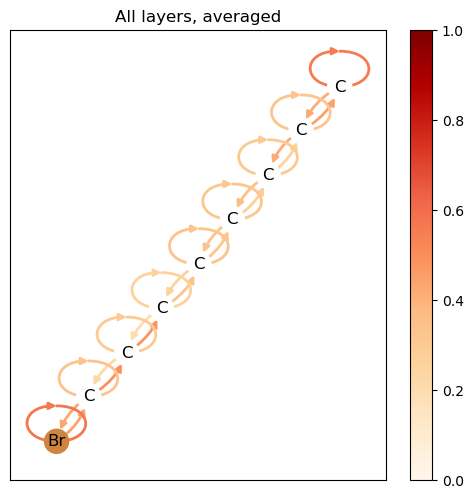

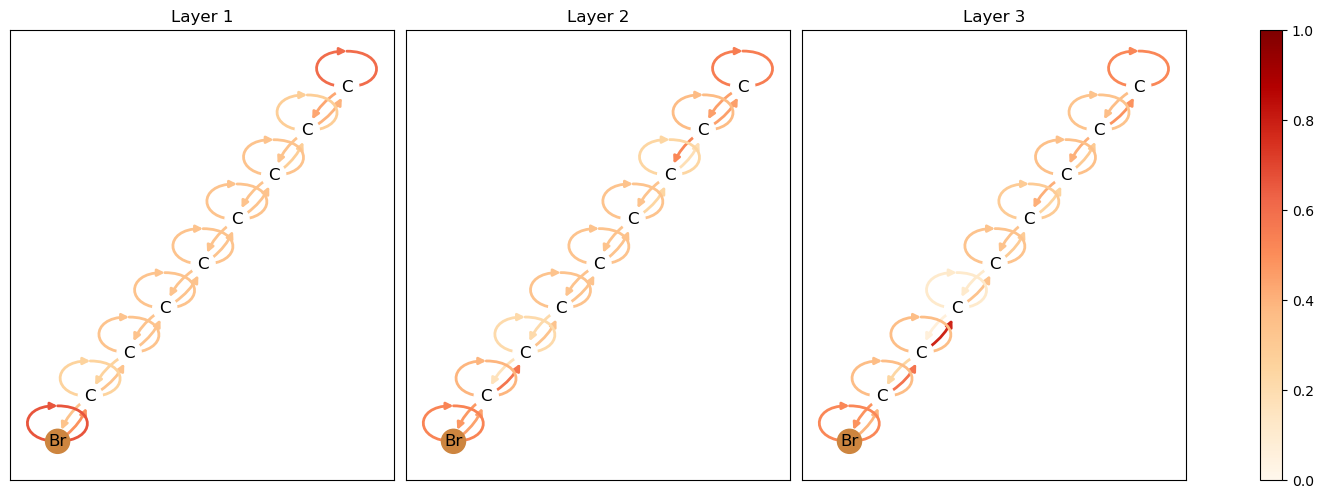

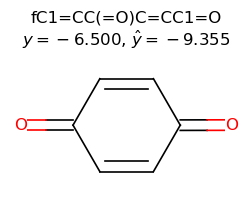

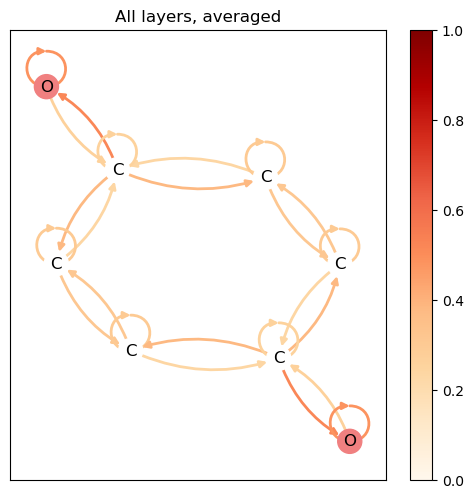

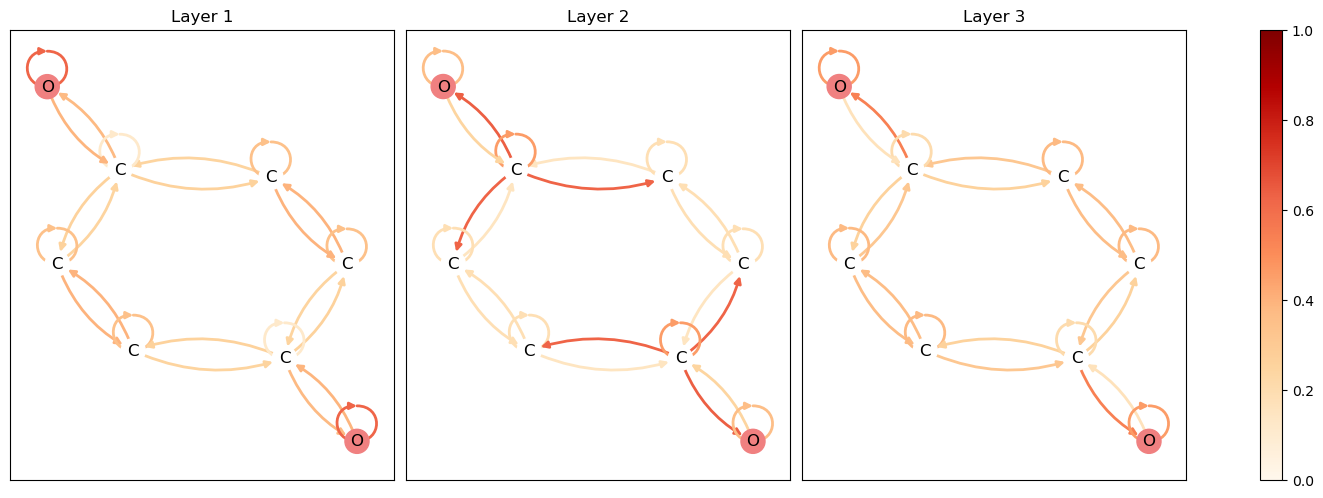

In [24]:
#Random graphs
import random

random_indices = random.sample(range(len(all_y)), 5)

for graph_num in random_indices:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)